In [20]:
import os, scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras import metrics
from keras.models import model_from_json
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error
import seaborn as sns

In [2]:
try:
    os.environ["HDF5_USE_FILE_LOCKING"]
except KeyError:
    os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'
    
img_rows, img_cols, img_channels = 224, 224, 3

# Load Face Data

In [3]:
lddf = pd.read_csv('utk_uncropped_all/utk_uncropped_age_predictions.csv', usecols=['age', 'gender', 'race', 'filename'])
lddf.dropna(inplace=True)
lddf.reset_index(inplace=True, drop=True)
print(lddf.shape)
lddf.head()

(19736, 4)


,age,gender,race,filename
0,100,0.0,0,100_0_0_20170112213500903.jpg
1,100,0.0,0,100_0_0_20170112215240346.jpg
2,100,1.0,0,100_1_0_20170110183726390.jpg
3,100,1.0,0,100_1_0_20170112213001988.jpg
4,100,1.0,0,100_1_0_20170112213303693.jpg


101 5


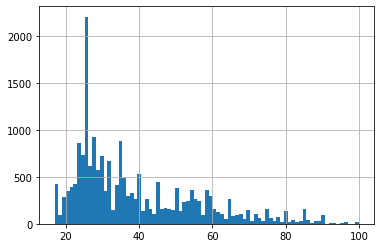

In [4]:
# keep only data points whose age os between 0 and 100
lddf = lddf[lddf['age'] <= 100]
lddf = lddf[lddf['age'] > 0]
lddf.reset_index(inplace=True, drop=True)
histogram = lddf['age'].hist(bins=lddf['age'].nunique())
# we already notice a bias in the dataset w.r.t. age, bulk of the data is in the age range 20 to 40

classes_age = max(lddf['age'].unique())+1
classes_race = max(lddf['race'].unique()[::-1])+1
print(classes_age, classes_race)

In [5]:
enableSplitsCreation = True

if enableSplitsCreation:  
    img_size = (img_rows, img_cols)
    def getImagePixels(image_path):
        img = image.load_img("utk_uncropped_all/%s" % image_path, grayscale=False, target_size=img_size)
        x = image.img_to_array(img).reshape(1, -1)[0]
        return x
    lddf['pixels'] = lddf['filename'].apply(getImagePixels)
    target_age = lddf['age'].values
    target_race = lddf['race'].values
    target_classes_age = keras.utils.to_categorical(target_age, 101)
    target_classes_race = keras.utils.to_categorical(target_race, classes_race)
    train_x, test_x, train_y_age, test_y_age = train_test_split(lddf, target_classes_age, test_size=0.30, random_state=42)
    train_idx = train_x.index.values
    test_idx = test_x.index.values
    train_y_race = target_classes_race[train_idx]
    test_y_race = target_classes_race[test_idx]
    joblib.dump(train_x, 'train_x.joblib')
    joblib.dump(test_x, 'test_x.joblib')
    joblib.dump(train_y_age, 'train_y_age.joblib')
    joblib.dump(test_y_age, 'test_y_age.joblib')
    joblib.dump(train_y_race, 'train_y_race.joblib')
    joblib.dump(test_y_race, 'test_y_race.joblib')
else:
    train_x = joblib.load('train_x.joblib')
    test_x = joblib.load('test_x.joblib')
    train_y_age = joblib.load('train_y_age.joblib')
    test_y_age = joblib.load('test_y_age.joblib')
    train_y_race = joblib.load('train_y_race.joblib')
    test_y_race = joblib.load('test_y_race.joblib')

print(train_x.shape, test_x.shape, train_y_age.shape, test_y_age.shape, train_y_race.shape, test_y_race.shape)
train_data = train_x[['age','race','gender']]
test_data = test_x[['age','race','gender']]

(13799, 5) (5915, 5) (13799, 101) (5915, 101) (13799, 5) (5915, 5)


In [6]:
features_train = []
for i in range(0, train_x.shape[0]):
    features_train.append(train_x['pixels'].values[i])
features_train = np.array(features_train)
features_train = features_train.reshape(features_train.shape[0], 224, 224, 3)
print(features_train.shape)

(13799, 224, 224, 3)


In [7]:
features_test = []
for i in range(0, test_x.shape[0]):
    features_test.append(test_x['pixels'].values[i])
features_test = np.array(features_test)
features_test = features_test.reshape(features_test.shape[0], 224, 224, 3)
print(features_test.shape)

(5915, 224, 224, 3)


In [8]:
# normalize features in [0, 1]
features_train /= 255
features_test /= 255

In [9]:
train_x = features_train
test_x = features_test

# Train Model

In [10]:
# VGG-Face model architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
model.load_weights('vgg_face_weights.h5')

# freeze all layers of VGG-Face except last 7
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(classes_age, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

age_model = Model(inputs=model.input, outputs=base_model_output)

sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='classification_age_model_utk.hdf5', 
    monitor = "val_loss", 
    verbose=1, 
    save_best_only=True, 
    mode = 'auto'
)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [28]:
plot_model(age_model, 
           to_file='model.png',
           show_shapes=True
          )

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [11]:
scores = []

# True retrains the NN
enableFit = True

if enableFit:
    epochs = 100
    batch_size = 512
    for i in range(epochs):
        print("epoch ",i)
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        score = age_model.fit(
            train_x[ix_train], train_y_age[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y_age)
            , callbacks=[checkpointer]
        )
        scores.append(score)
    #restore the best weights
    from keras.models import load_model
    age_model = load_model("classification_age_model_utk.hdf5")
    age_model.save_weights('age_model_weights_utk.h5')
else:
    age_model.load_weights("age_model_weights_utk.h5")

epoch  0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 102s 199ms/step - loss: 4.1782 - acc: 0.0898 - val_loss: 3.8992 - val_acc: 0.1119

Epoch 00001: val_loss improved from inf to 3.89922, saving model to classification_age_model_utk.hdf5
epoch  1
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 90s 175ms/step - loss: 3.8449 - acc: 0.1172 - val_loss: 3.7851 - val_acc: 0.1222

Epoch 00001: val_loss improved from 3.89922 to 3.78508, saving model to classification_age_model_utk.hdf5
epoch  2
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 90s 175ms/step - loss: 3.7816 - acc: 0.1172 - val_loss: 3.7358 - val_acc: 0.1187

Epoch 00001: val_loss improved from 3.78508 to 3.73579, saving model to classification_age_model_utk.hdf5
epoch  3
Train on 

512/512 [==============================] - 89s 174ms/step - loss: 3.4270 - acc: 0.1445 - val_loss: 3.4957 - val_acc: 0.1315

Epoch 00001: val_loss did not improve from 3.47352
epoch  29
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 173ms/step - loss: 3.4333 - acc: 0.1680 - val_loss: 3.5013 - val_acc: 0.1224

Epoch 00001: val_loss did not improve from 3.47352
epoch  30
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 174ms/step - loss: 3.4255 - acc: 0.1523 - val_loss: 3.5204 - val_acc: 0.1146

Epoch 00001: val_loss did not improve from 3.47352
epoch  31
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 88s 172ms/step - loss: 3.4150 - acc: 0.1465 - val_loss: 3.5001 - val_acc: 0.1214

Epoch 00001: val_loss did not improve from 3.47352
epoch  32
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [===================

Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 175ms/step - loss: 3.1046 - acc: 0.2285 - val_loss: 3.5874 - val_acc: 0.1123

Epoch 00001: val_loss did not improve from 3.47352
epoch  63
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 88s 172ms/step - loss: 3.1766 - acc: 0.1914 - val_loss: 3.6548 - val_acc: 0.0899

Epoch 00001: val_loss did not improve from 3.47352
epoch  64
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 88s 173ms/step - loss: 3.1259 - acc: 0.1934 - val_loss: 3.5393 - val_acc: 0.1072

Epoch 00001: val_loss did not improve from 3.47352
epoch  65
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 174ms/step - loss: 3.0911 - acc: 0.2305 - val_loss: 3.5554 - val_acc: 0.0950

Epoch 00001: val_loss did not improve from 3.47352
epoch  66
Train on 512 samples, valida


Epoch 00001: val_loss did not improve from 3.47352
epoch  96
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 174ms/step - loss: 2.7842 - acc: 0.2773 - val_loss: 3.5610 - val_acc: 0.1077

Epoch 00001: val_loss did not improve from 3.47352
epoch  97
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 88s 172ms/step - loss: 2.7886 - acc: 0.3184 - val_loss: 3.5567 - val_acc: 0.1123

Epoch 00001: val_loss did not improve from 3.47352
epoch  98
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 88s 173ms/step - loss: 2.8521 - acc: 0.2812 - val_loss: 3.5584 - val_acc: 0.1082

Epoch 00001: val_loss did not improve from 3.47352
epoch  99
Train on 512 samples, validate on 5915 samples
Epoch 1/1
512/512 [==============================] - 89s 174ms/step - loss: 2.6422 - acc: 0.3184 - val_loss: 3.5481 - val_acc: 0.1109

Epoch 00001: val_loss did n

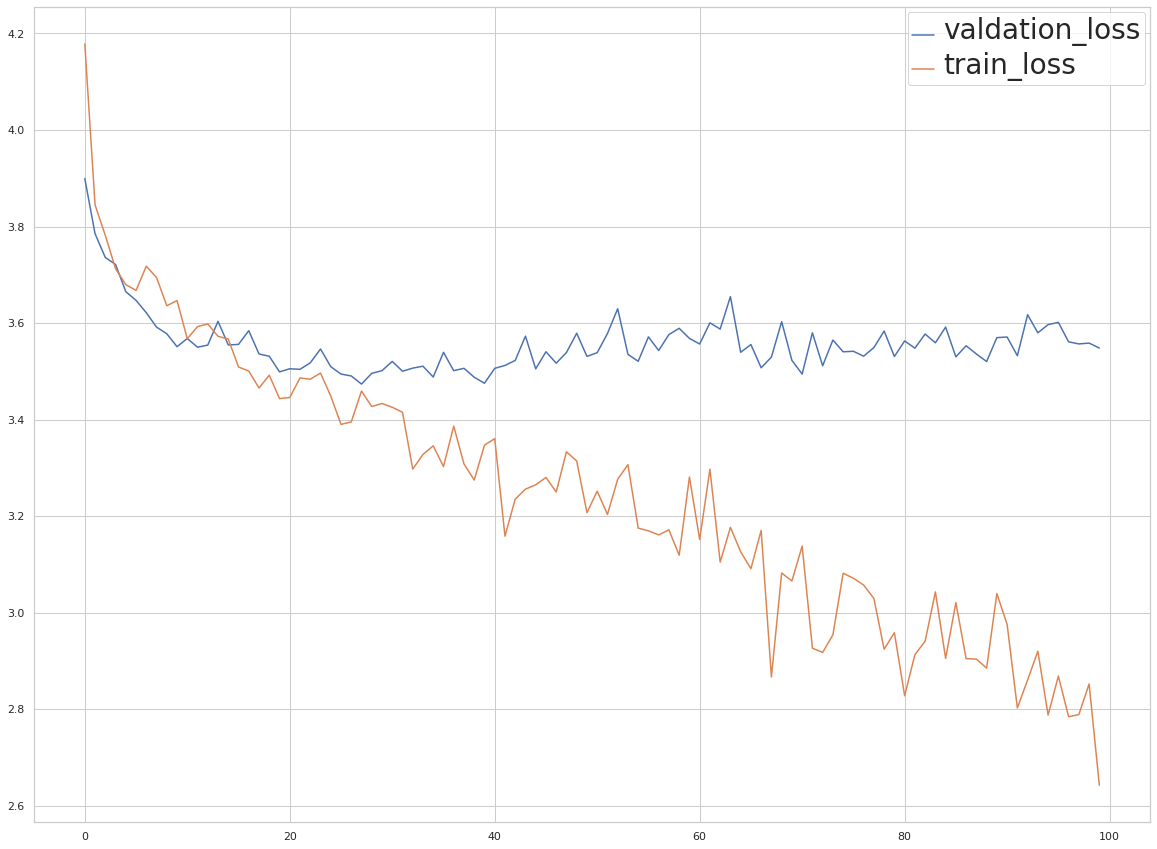

In [46]:
#Only prints if model is trained
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

axes = plt.gca()
plt.rcParams["figure.figsize"] = (20,15)
plt.plot(val_loss_change, label='valdation_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.setp(axes.get_legend().get_texts(), fontsize='28')
plt.show()

# Evaluate Model on Test Data

## Overall performance

In [58]:
age_predictions_train = age_model.predict(train_x)
y_pred_age_train = np.argmax(age_predictions_train, axis=-1)
train_data['pred_age'] = y_pred_age_train

In [17]:
age_predictions = age_model.predict(test_x)
y_pred_age = np.argmax(age_predictions, axis=-1)
test_data['pred_age'] = y_pred_age
test_data.to_csv('age_predictions_kessel_run.csv')

In [59]:
mean_absolute_error(train_data['age'], train_data['pred_age'])

7.793318356402638

In [47]:
mean_absolute_error(test_data['age'], test_data['pred_age'])

8.70414201183432

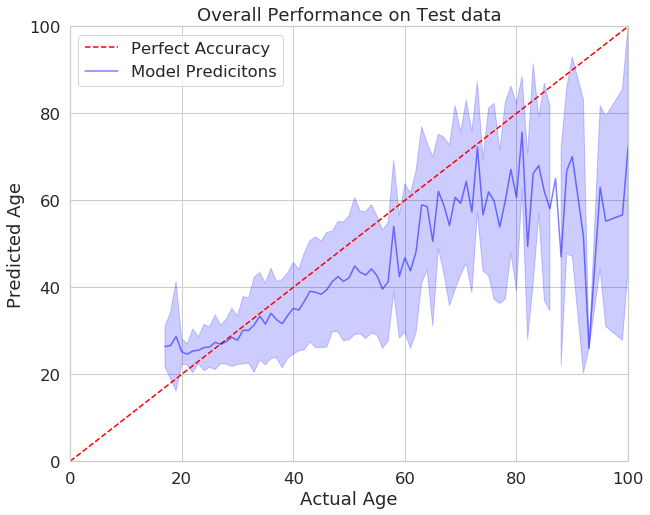

In [135]:
# Plot of performance on full test data
plt.figure(figsize=(10,8))
sns.set(style="whitegrid", font_scale=1.5)

r = range(0,101)
plt.plot(r, r, color = 'red', linestyle = "--", label="Perfect Accuracy")
sns.lineplot(x="age", y="pred_age", data=test_data, ci="sd", alpha=0.5, color = "blue", 
             label="Model Predicitons")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.legend(numpoints=1, loc='best')
plt.title('Overall Performance on Test data')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

## Performance across age groups

In [136]:
test_data_age_20_40 = test_data[(test_data['age']>=20)&(test_data['age']<40)]
test_data_age_40_60 = test_data[(test_data['age']>=40)&(test_data['age']<60)]
test_data_age_60_plus = test_data[(test_data['age']>=60)]

4.684946838276441 12.889128869690424 19.38993710691824


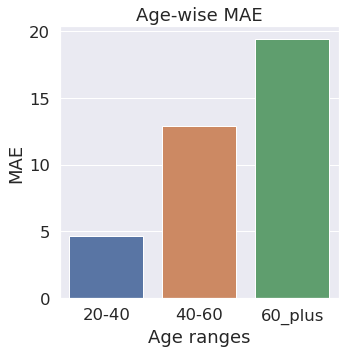

In [137]:
mae_20_40 = mean_absolute_error(test_data_age_20_40['age'], test_data_age_20_40['pred_age'])
mae_40_60 = mean_absolute_error(test_data_age_40_60['age'], test_data_age_40_60['pred_age'])
mae_60_plus = mean_absolute_error(test_data_age_60_plus['age'], test_data_age_60_plus['pred_age'])
print(mae_20_40, mae_40_60, mae_60_plus)
df = pd.DataFrame(data=[['20-40', mae_20_40],['40-60', mae_40_60], ['60_plus',mae_60_plus]], columns=['Age range', 'MAE'])
sns.set(font_scale=1.5)
plt.figure(figsize=(5,5))
b = sns.barplot(x='Age range', y='MAE', data=df)
b.axes.set_title("Age-wise MAE")
b.set_xlabel("Age range")
b.set_ylabel("MAE")
b.axes.set_xlabel('Age ranges')
plt.show()

## Performance across gender

In [151]:
from math import sqrt
test_data_male = test_data[(test_data['gender']==0)]
test_data_female = test_data[(test_data['gender']==1)]
mae_male = sqrt(mean_squared_error(test_data_male['age'], test_data_male['pred_age']))
mae_female = sqrt(mean_squared_error(test_data_female['age'], test_data_female['pred_age']))
print(mae_male, mae_female)

12.837877018153241 14.003408909801244


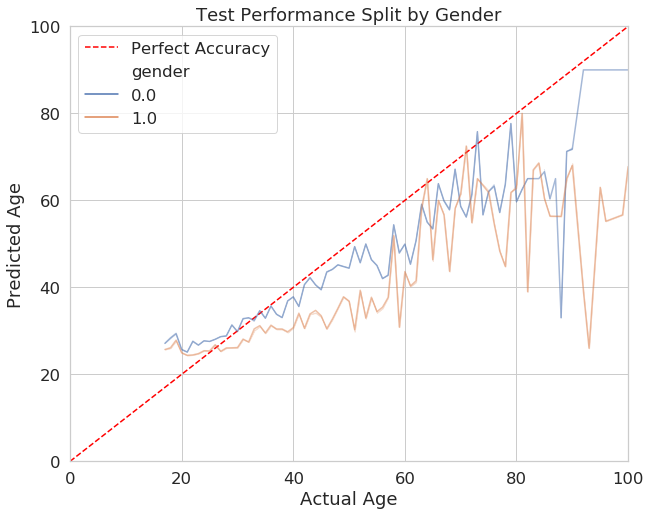

In [147]:
#By Gender
plt.figure(figsize=(10,8))
# Plot the responses for different events and regions
sns.set(style="whitegrid", font_scale=1.5)
r = range(0,101)
plt.plot(r, r, color = 'red', linestyle = "--", label="Perfect Accuracy")
sns.lineplot(x="age", y="pred_age", hue="gender", data=test_data, ci=1, alpha=0.5)
axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.title('Test Performance Split by Gender')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

## Performance across racial groups

In [228]:
import numpy as np
def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(np.diff( training_series)).sum()/(n)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [229]:
from scipy.stats import median_absolute_deviation
train_data['race']

15347    3
7907     0
19231    3
11193    1
15764    0
        ..
11284    3
11964    2
5390     2
860      1
15795    0
Name: race, Length: 13799, dtype: int64

In [230]:
test_data_white = test_data[(test_data['race']==0)&(test_data['age']<80)]
test_data_black = test_data[(test_data['race']==1)&(test_data['age']<80)]
test_data_asian = test_data[(test_data['race']==2)&(test_data['age']<80)]
test_data_indian = test_data[(test_data['race']==3)&(test_data['age']<80)]

In [231]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

print((mean_absolute_error(test_data_white['age'], test_data_white['pred_age'])))
print((mean_absolute_error(test_data_black['age'], test_data_black['pred_age'])))
print((mean_absolute_error(test_data_asian['age'], test_data_asian['pred_age'])))
print((mean_absolute_error(test_data_indian['age'], test_data_indian['pred_age'])))
print("--------------")
print(MASE(train_data[train_data['race']==0]['age'], test_data_white['age'], test_data_white['pred_age']))
print(MASE(train_data[train_data['race']==1]['age'], test_data_black['age'], test_data_black['pred_age']))
print(MASE(train_data[train_data['race']==2]['age'], test_data_asian['age'], test_data_asian['pred_age']))
print(MASE(train_data[train_data['race']==3]['age'],test_data_indian['age'], test_data_indian['pred_age']))

9.490831556503199
7.949729311678268
6.590379008746356
7.279454722492697
--------------
0.45833558248540307
0.5630141224735111
0.4159983822485167
0.48833111267820223


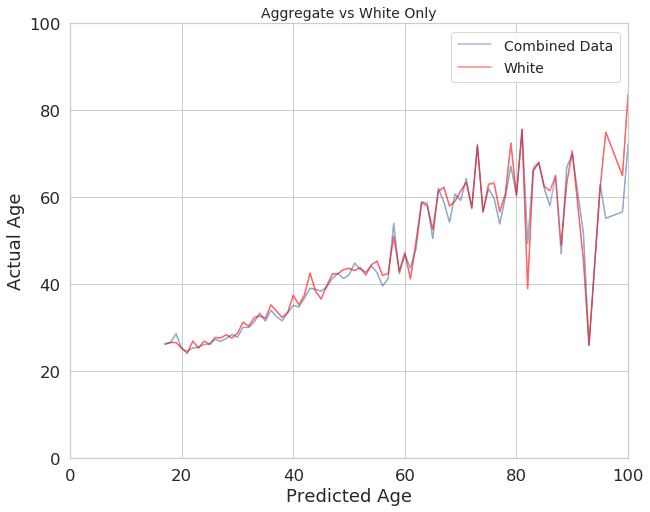

In [170]:
# Race = White
mask = test_data["race"] == 0
race = test_data[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(10,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.lineplot(x="age", y="pred_age", data=test_data, ci=1, alpha=0.5, label="Combined Data")
sns.lineplot(x="age", y="pred_age", data=race, ci=1, color= 'red', alpha=0.5, label="White")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.legend(numpoints=1, loc='best')
plt.title('Aggregate vs White Only', fontsize='14')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.setp(axes.get_legend().get_texts(), fontsize='14')
plt.show()

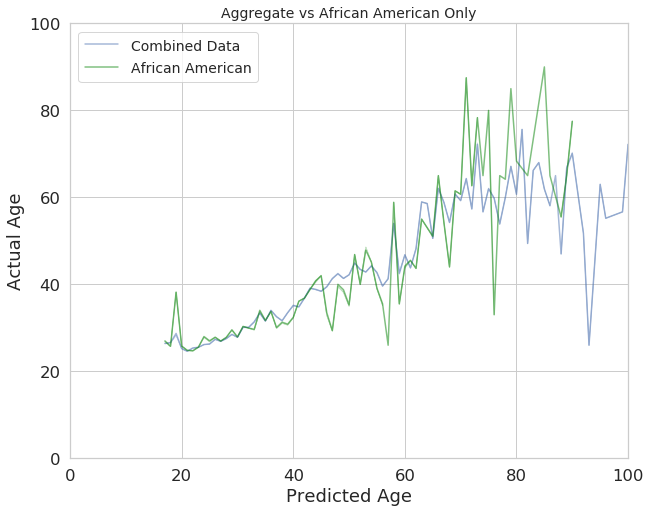

In [173]:
# Race = African American
mask = test_data["race"] == 1
race = test_data[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(10,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.lineplot(x="age", y="pred_age", data=test_data, ci=1, alpha=0.5, label="Combined Data")
sns.lineplot(x="age", y="pred_age", data=race, ci=1, color= 'green', alpha=0.5, label="African American")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.legend(numpoints=1, loc='best')
plt.title('Aggregate vs African American Only', fontsize='14')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.setp(axes.get_legend().get_texts(), fontsize='14')
plt.show()

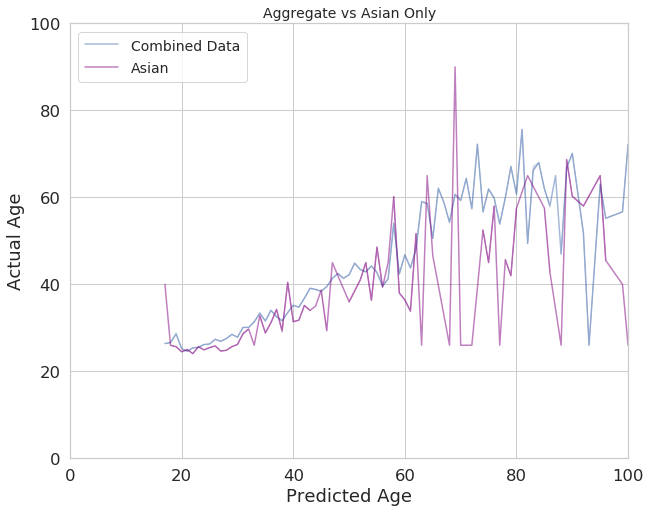

In [176]:
# Race = Asian
mask = test_data["race"] == 2
race = test_data[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(10,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.lineplot(x="age", y="pred_age", data=test_data, ci=1, alpha=0.5, label="Combined Data")
sns.lineplot(x="age", y="pred_age", data=race, ci=1, color= 'purple', alpha=0.5, label="Asian")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.legend(numpoints=1, loc='best')
plt.title('Aggregate vs Asian Only', fontsize='14')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.setp(axes.get_legend().get_texts(), fontsize='14')
plt.show()

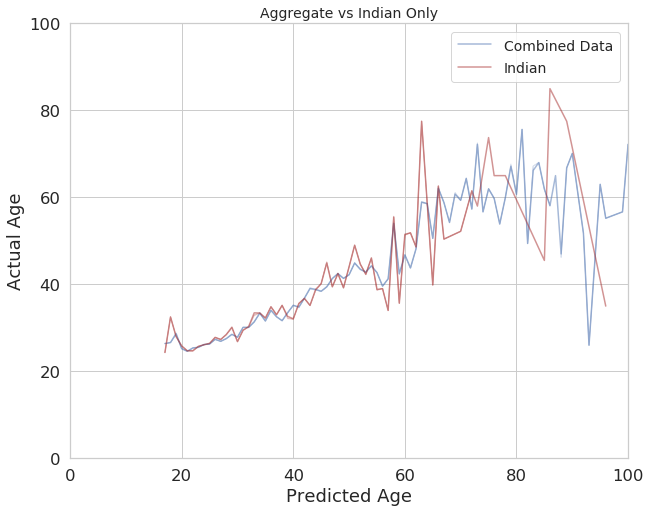

In [181]:
# Race = Indian
mask = test_data["race"] == 3
race = test_data[mask]

# Plot the responses for different events and regions
plt.figure(figsize=(10,8))
sns.set(style="whitegrid", font_scale=1.5)

sns.lineplot(x="age", y="pred_age", data=test_data, ci=1, alpha=0.5, label="Combined Data")
sns.lineplot(x="age", y="pred_age", data=race, ci=1, color= 'brown', alpha=0.5, label="Indian")

axes = plt.gca()
axes.set_xlim([0,100])
axes.set_ylim([0,100])
plt.legend(numpoints=1, loc='best')
plt.title('Aggregate vs Indian Only', fontsize='14')
plt.xlabel('Predicted Age')
plt.ylabel('Actual Age')
plt.setp(axes.get_legend().get_texts(), fontsize='14')
plt.show()